In [1]:
import math
import os
import natsort
import skimage
import numpy as np
import pandas as pd
from natsort import natsorted, ns
from skimage import io, color
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib import markers
from matplotlib.lines import lineStyles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC, l1_min_c
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import scipy.misc
from scipy import ndimage
import seaborn as sns
import warnings
from IPython.display import display, HTML

%matplotlib inline 

In [2]:
#Directory
data = 'HPTLCRaw\\'

### Things only Present in this Gen
    Calculate Min Value of C such that the models is guaranteed not to be empty
    Train Model, Get Accuracies, Get # of Non-Zero Weights - With Large Regularizers
    
    Combining Views for improved feature selection and sparser weight coefficients
        * Append all Views
        * Append all Targets
        *** Train Model WITH SMALLER REGULARIZERS, Get Accuracies, Get # of Non-Zero Weights

#### Why 5.5?
There was an error discovered where the number of non-zero weight counts was wrong. We wanted the number of features being used. Counting all non-zero weights allows some columns to be counted more than once. Fixed this by changing previous counting method:

`nonzero_weight_cnt.append(np.count_nonzero(model.coef_))`

to:
`nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))`

### Color Import

##### Import images as Color for visual identification purposes

In [4]:
list_files_co = os.listdir(data)
list_files_co = natsorted(list_files_co)
image_list_co = []
for filename in list_files_co:
    image_list_co.append(io.imread(data+filename)[:,:,:3])

##### Plot Every File in Directory as Colored Image

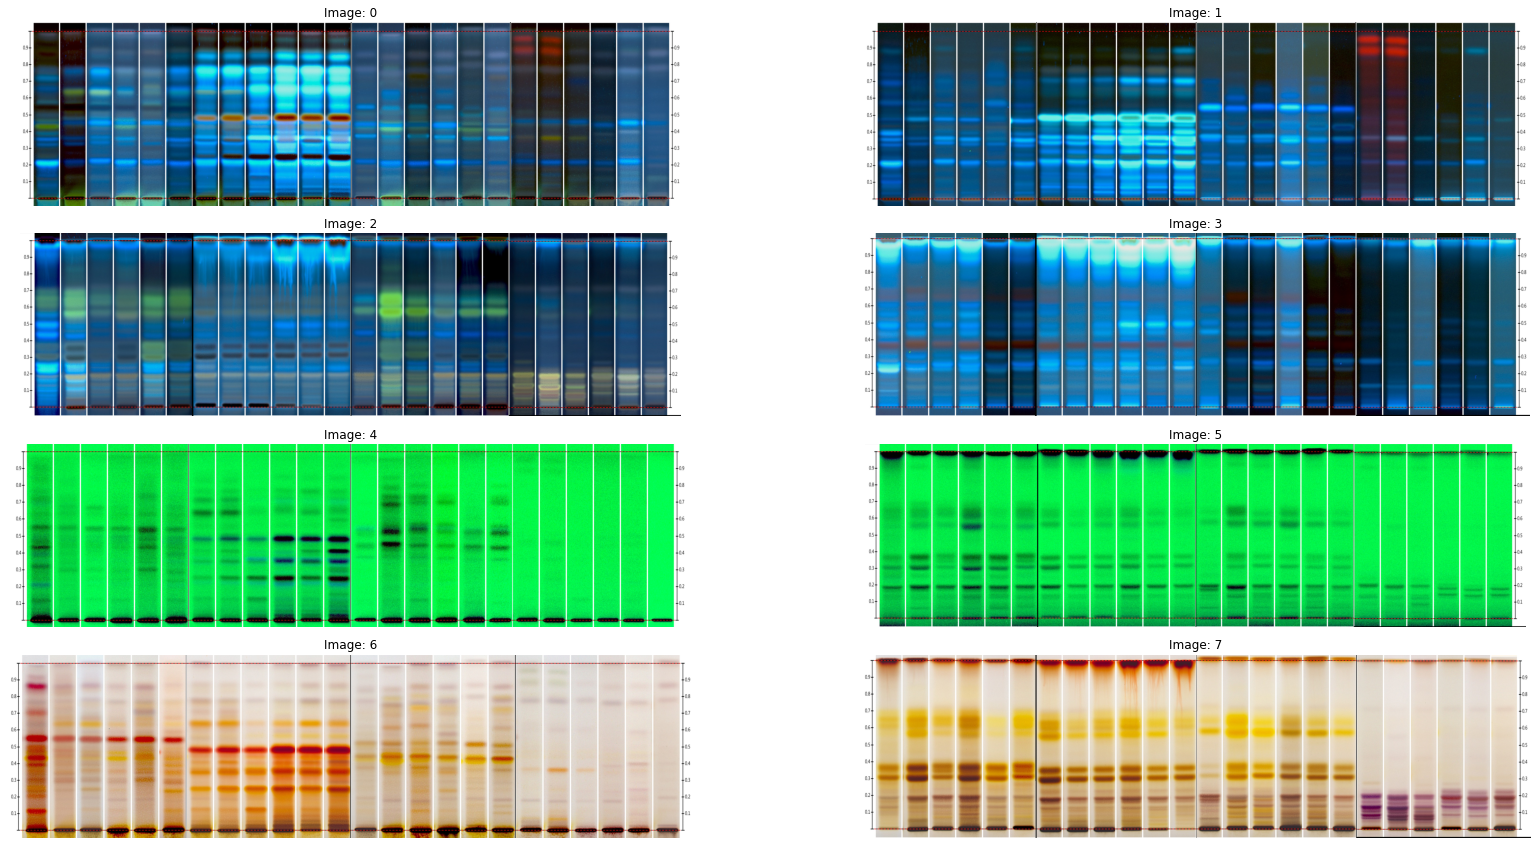

In [5]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(image_list_co):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    sub.set_title('Image: '+str(i))
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=0.15)

### Grey Scale Import

##### Import Images as Grey Scale

In [3]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(color.rgb2gray(io.imread(data+filename)[:,:,:3]))

##### Crop all Images

In [4]:
cropped_img_list = []
for image in image_list:
    cropped_img_list.append(image[70:1100,96:-84])

##### Plot Every Cropped File as a Greyscale Image

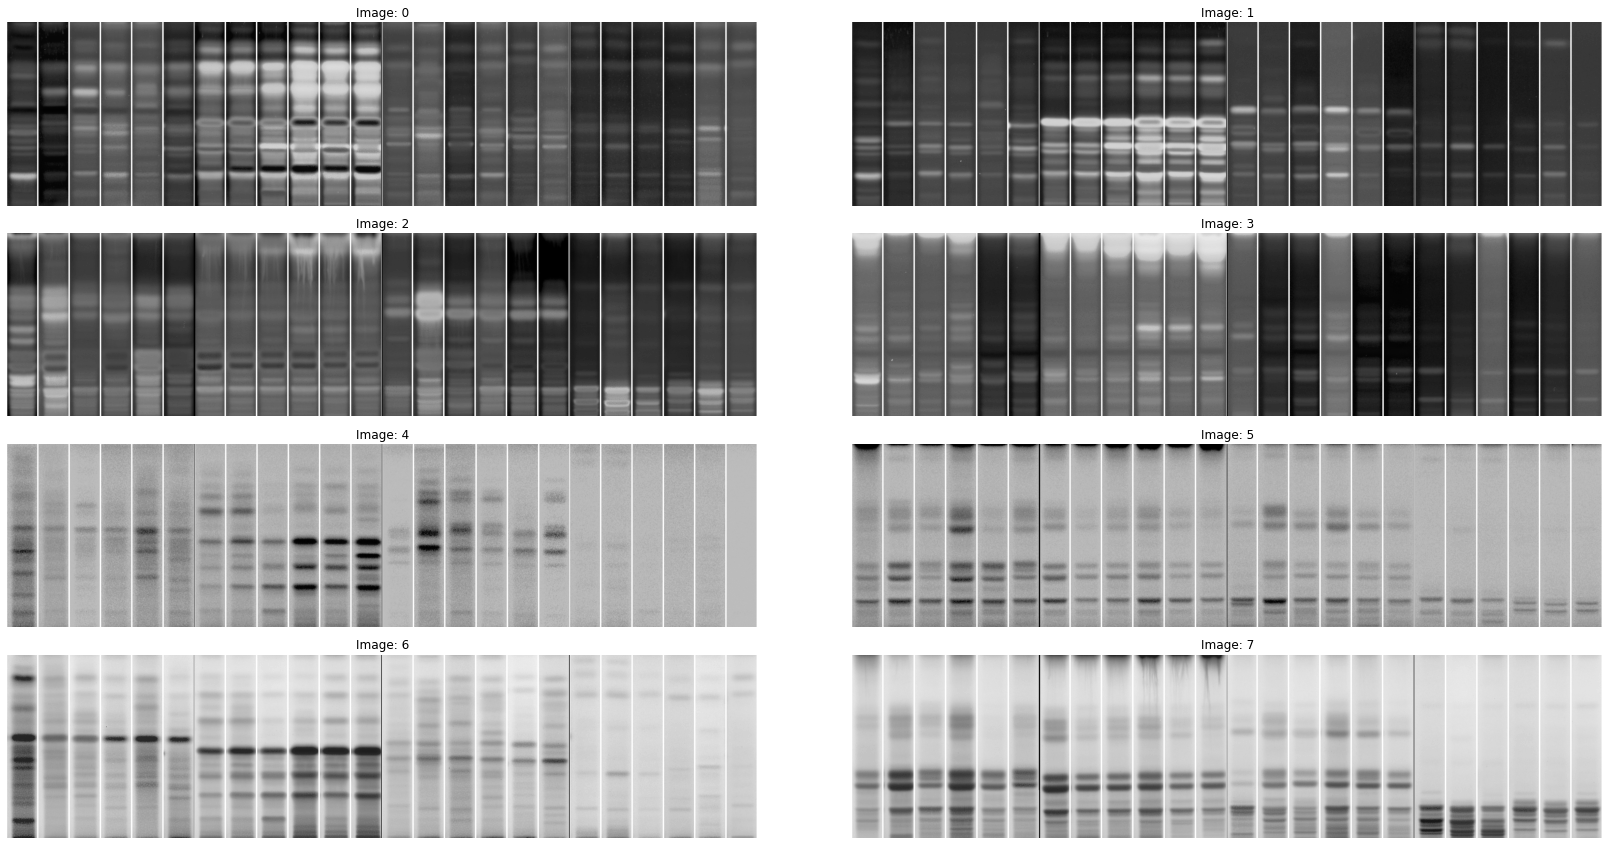

In [5]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    sub.set_title('Image: '+str(i))
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

##### Verifying Shape of each Cropped Image


In [6]:
for i in range(len(cropped_img_list)):
    print(np.shape(cropped_img_list[i]))

(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)


### Algorithm to determine crop locations

In [7]:
def det_crop_locations(ar):
    maxVal = ar.max()
    res = []
    res.append([0,0])
    n = len(ar)

    i = 10
    while i < len(ar-5):
        # While we are within bounds and
        # we have not found a peak or
        # haven't yet travelled at least 100 pixels or
        # are not within 5% of the max value
        # increment i
        while (i < n-5) and (not (ar[i] >= ar[i-1] and ar[i] >= ar[i+1]) or not (i - res[-1][0] > 100) or not(ar[i] > (.85*maxVal))):
            i += 1

        #if we reach the end of the image, break the loop
        if i >= n-5:
            break

        # Add Back wall of single strip to q
        res[-1][1] = i - 15
        
        #Add front wall to q
        res.append([i + 15,0])
        
    #remove last appended crop as it is at the end of the image and therefore not useful
    res.pop()
    return res

#### Use Function to Determine Crop Locations of Each Image

In [8]:
crops_list = []
for cropped_img in cropped_img_list:
    temp = pd.DataFrame(cropped_img)
    temp_hi_cnt = temp[temp>.8].count()
    temp_low_cnt = temp[temp==0].count()
    temp_cnt = temp_hi_cnt + temp_low_cnt
    crops_list.append(det_crop_locations(temp_cnt.copy()))

In [9]:
# Verify Number of Crops for Each Image
for crops in crops_list:
    print(len(crops))

24
24
24
24
24
24
24
24


##### Generate Plot of Crop Locations for all Images -> Common Sense Check Reasonability of Algorithm Results

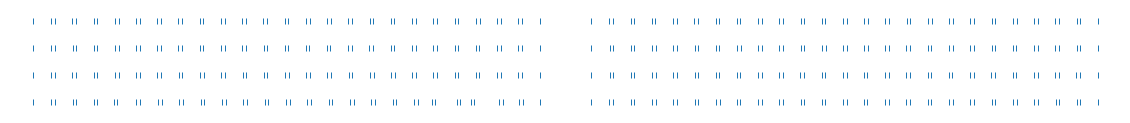

In [10]:
fig = plt.figure(figsize=(20, 2))
for i, crops in enumerate(crops_list):
    temp = pd.DataFrame(crops).to_numpy().flatten()
    sub = fig.add_subplot(4,2,i+1)
    sub.axis('off')
    sub.plot(temp,np.zeros_like(temp),'|')
plt.tight_layout
fig.subplots_adjust(wspace=.001, hspace=0)

##### Cropping Images and adding Individual Slices to new Array

In [11]:
multiview_strip_array = []

#For every View
for i, cropped_image in enumerate(cropped_img_list):
    min_width = float('inf')
    strip_array = []

    #First find the minimum width of all the crops
    for crop in crops_list[i]:
        front, back = crop
        min_width = min(min_width,back-front)

    #Get half of that min width
    min_width_half = int((min_width-2)/2)

    #For each of the crops, crop them from their own midpoint +- the mind_width_half value
    for crop in crops_list[i]:
        front, back = crop
        strip_mid = int(back/2 + front/2)
        min_front = strip_mid - min_width_half
        min_back = min_width_half + strip_mid
        strip_array.append(cropped_image[:,min_front:min_back])

    multiview_strip_array.append(strip_array)

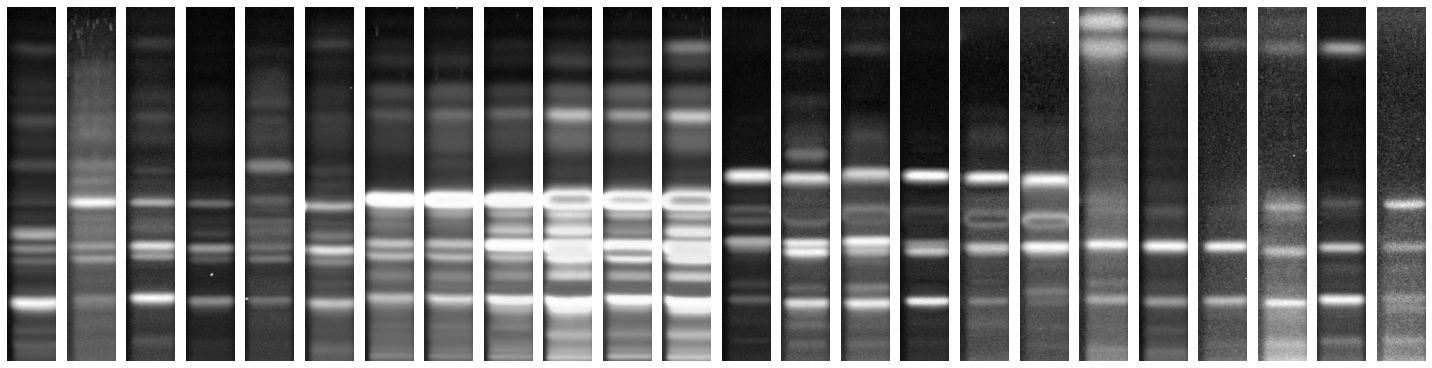

In [12]:
# Individual Print
# strip_array = strip_array_list[1]
strip_array = multiview_strip_array[1]
fig = plt.figure(figsize=(20, 10))
for i, strip in enumerate(strip_array):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    sub.imshow(strip,cmap='gray')
plt.tight_layout()

### Transforming each Strip in array to a 1D Vector by getting average value of each row

In [13]:
multiview_strip_row_avg_list = []

for strip_array in multiview_strip_array:
    strip_row_avg = []

    for i, strip in enumerate(strip_array):
        strip_row_avg.append([])
        for row in strip:
            strip_row_avg[i].append(row.mean())

    multiview_strip_row_avg_list.append(strip_row_avg)

In [14]:
np.shape(multiview_strip_row_avg_list[0][0])

(1030,)

In [15]:
np.shape(np.transpose([multiview_strip_row_avg_list[0][i] for k in range(min_width)]))

(1030, 140)

#### Plotting arrays of average values to verify mean of each row

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

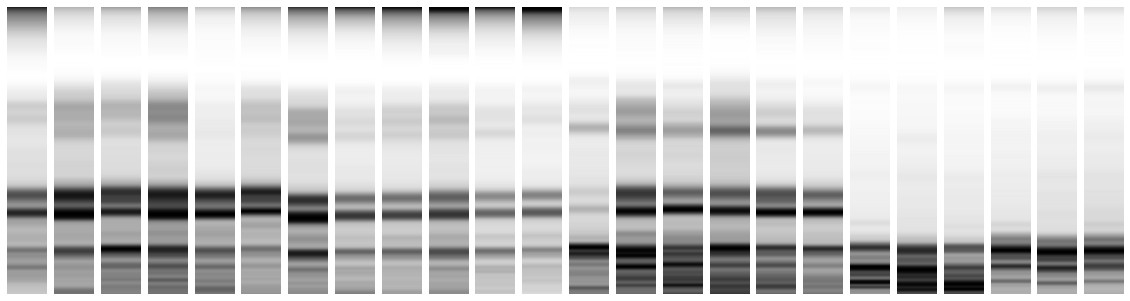

In [16]:
# Individual
fig = plt.figure(figsize=(20, 10)) 
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    img = [multiview_strip_row_avg_list[-1][i] for k in range(min_width)]
    img = np.transpose(img)
    sub.imshow(img, cmap='gray')
plt.tight_layout

### Setting up Target Values & Dictionary Mapping

In [17]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


In [18]:
np.shape(multiview_strip_row_avg_list)

(8, 24, 1030)

In [19]:
np.shape(multiview_strip_row_avg_list[0])

(24, 1030)

In [20]:
#Done for the purposes of appending all views into 1 long feature vector later
no_targets_multiview_strip_row_avg_list = np.array(multiview_strip_row_avg_list).copy()

##### Append Targets to feature array

In [21]:
for strip_row_avg in multiview_strip_row_avg_list:
    for i in range(6):
        # strip_row_avg[i].append(1)
        strip_row_avg[i] = np.append(strip_row_avg[i],1)
    for i in range(6,12):
        # strip_row_avg[i].append(2)
        strip_row_avg[i] = np.append(strip_row_avg[i],2)
    for i in range(12,18):
        # strip_row_avg[i].append(3)
        strip_row_avg[i] = np.append(strip_row_avg[i],3)
    for i in range(18,21):
        # strip_row_avg[i].append(4)
        strip_row_avg[i] = np.append(strip_row_avg[i],4)
    for i in range(21,24):
        # strip_row_avg[i].append(5)
        strip_row_avg[i] = np.append(strip_row_avg[i],5)

In [22]:
#Verifying Shape of Multiview Multi-Dimensional Array
print(np.shape(multiview_strip_row_avg_list))

(8, 24, 1031)


In [23]:
# Verifying values are w/n the 0 - 1 range
print(np.shape(multiview_strip_row_avg_list[0][0]))
print(max(multiview_strip_row_avg_list[0][0]))
print(min(multiview_strip_row_avg_list[0][0]))

(1031,)
1.0
0.046075564761115705


### Calculate Min Value of C such that the models is guaranteed not to be empty

In [24]:
#Minimum C where should the value be lower, the model is guaranteed to be empty
min_c_vals = []
for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):
    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    min_c_vals.append(l1_min_c(df_feat,df_target).round(3))
print(min_c_vals)

[0.028, 0.028, 0.028, 0.028, 0.028, 0.028, 0.028, 0.028]


### Accuracy vs # of Unique Columns w/ a Non-zero Weight and C

In [27]:
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,3,4,5,6,7,8]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-3,
                        C=r_c)

        #Print Model Params
        # print("Model Params: "+str(model.get_params()))

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('Strip '+str(i+1))
    # print('Accuracy: '+str(accuracy))
    # print('Nonzero_Weight_Cnt: '+str(nonzero_weight_cnt))
    # print('Regularizers: '+str(regularizers))
    # print()
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    display(results)

Strip 1


,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.250,0.1,0
1,0.542,0.2,4
2,0.750,0.3,7
3,0.750,0.4,12
4,0.750,0.5,15
5,0.750,0.6,18
6,0.750,0.7,24
7,0.750,0.8,26
8,0.750,0.9,27
9,0.750,1.0,32


Strip 2


,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.250,0.1,0
1,0.500,0.2,3
2,0.750,0.3,13
3,0.750,0.4,17
4,0.750,0.5,16
5,0.750,0.6,15
6,0.750,0.7,18
7,0.792,0.8,17
8,0.750,0.9,17
9,0.792,1.0,19


Strip 3


,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.250,0.1,0
1,0.500,0.2,2
2,0.500,0.3,8
3,0.500,0.4,9
4,0.583,0.5,16
5,0.792,0.6,23
6,0.875,0.7,24
7,0.917,0.8,24
8,0.875,0.9,23
9,1.000,1.0,30


Strip 4


,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.375,0.1,4
1,0.542,0.2,5
2,0.542,0.3,7
3,0.542,0.4,7
4,0.542,0.5,13
5,0.542,0.6,15
6,0.500,0.7,17
7,0.500,0.8,19
8,0.542,0.9,25
9,0.583,1.0,26


Strip 5


,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.458,0.1,2
1,0.667,0.2,6
2,0.667,0.3,9
3,0.667,0.4,9
4,0.708,0.5,12
5,0.708,0.6,13
6,0.708,0.7,18
7,0.750,0.8,20
8,0.708,0.9,21
9,0.708,1.0,25


Strip 6


,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.375,0.1,1
1,0.583,0.2,4
2,0.625,0.3,13
3,0.625,0.4,11
4,0.625,0.5,19
5,0.667,0.6,19
6,0.667,0.7,23
7,0.708,0.8,24
8,0.792,0.9,26
9,0.833,1.0,25


Strip 7


,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.750,0.1,4
1,0.750,0.2,8
2,0.750,0.3,12
3,0.750,0.4,14
4,0.750,0.5,21
5,0.750,0.6,26
6,0.792,0.7,37
7,0.917,0.8,42
8,0.917,0.9,45
9,0.917,1.0,52


Strip 8


,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.583,0.1,2
1,0.833,0.2,7
2,0.833,0.3,14
3,0.833,0.4,16
4,0.833,0.5,26
5,0.958,0.6,34
6,0.958,0.7,39
7,0.958,0.8,46
8,0.958,0.9,49
9,0.958,1.0,53


Strip 3
Accuracy: 
[0.25, 0.5, 0.5, 0.5, 0.583, 0.792, 0.875, 0.917, 0.875, **1.0**, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Nonzero_Weight_Cnt: 
[0, 2, 8, 10, 18, 27, 30, 31, 31, **38**, 67, 101, 115, 125, 135, 158, 176]

Regularizers: 
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8]

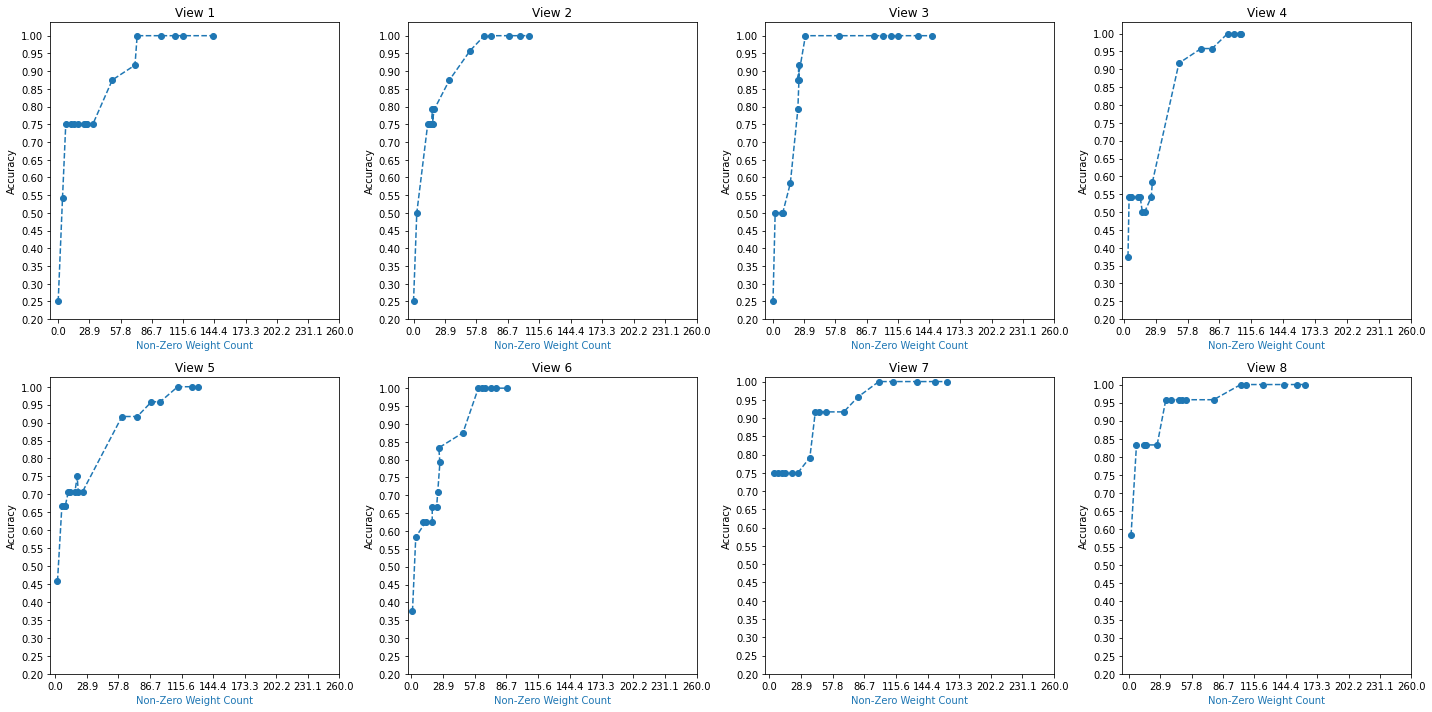

In [28]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(4, 21)])
    ax.set_xticks(np.linspace(0,260,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

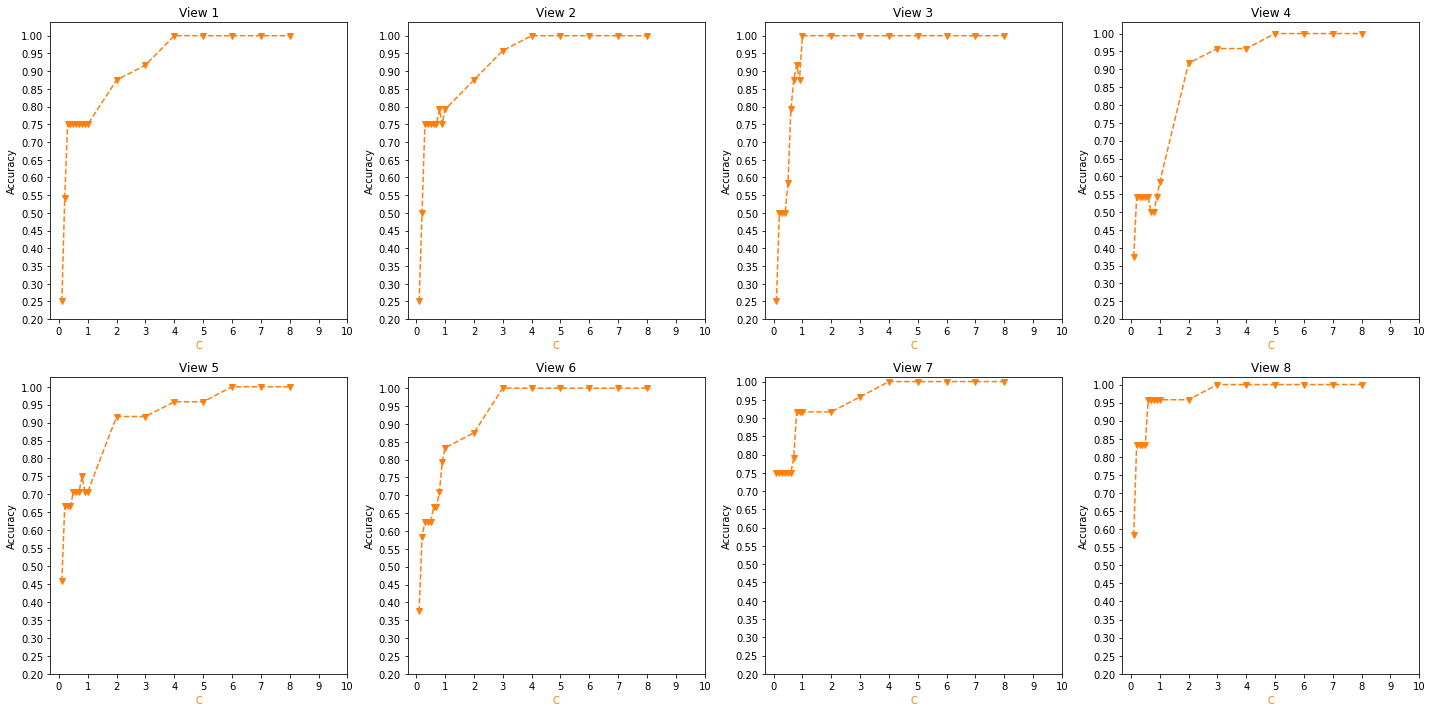

In [29]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(4, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

## Combining Views for improved feature selection and sparser weight coefficients

### Append all Views

In [31]:
print(np.shape(no_targets_multiview_strip_row_avg_list))

(8, 24, 1030)


In [32]:
joined_multiview_strip_row_avg_list = np.array(no_targets_multiview_strip_row_avg_list).transpose(1,2,0)
joined_multiview_strip_row_avg_list = joined_multiview_strip_row_avg_list.reshape(24,-1)
print(np.shape(joined_multiview_strip_row_avg_list))

(24, 8240)


### Append all Targets

In [33]:
print(type(joined_multiview_strip_row_avg_list[0]))
temp = []
for i in range(6):
    temp.append(np.append(joined_multiview_strip_row_avg_list[i],1))
for i in range(6,12):
    temp.append(np.append(joined_multiview_strip_row_avg_list[i],2))
for i in range(12,18):
    temp.append(np.append(joined_multiview_strip_row_avg_list[i],3))
for i in range(18,21):
    temp.append(np.append(joined_multiview_strip_row_avg_list[i],4))
for i in range(21,24):
    temp.append(np.append(joined_multiview_strip_row_avg_list[i],5))
joined_multiview_strip_row_avg_list = np.array(temp).copy()

<class 'numpy.ndarray'>


In [34]:
print(np.shape(joined_multiview_strip_row_avg_list))

(24, 8241)


### Train Model, Get Accuracies, Get # of Non-Zero Weights

In [36]:
accuracy = []
nonzero_weight_cnt = []
regularizers =[.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,3,4,5,6,7,8]

#Convert to Dataframe
strip_row_avg = pd.DataFrame(joined_multiview_strip_row_avg_list)

#Get Features
df_feat = strip_row_avg.iloc[:,:-2]

#Get Targets & Format to 1D vector
df_target = strip_row_avg.iloc[:,-1:]
df_target = df_target.values.ravel()

# print(np.shape(df_feat))
# print(np.shape(df_target))

#Create Model
model = LinearSVC()

#Set Model Parameters
for r_c in regularizers:

    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False,
                    tol=2e-3,
                    C=r_c)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Append Count of Number of Non-Zero Weights
    nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))

    # print("N_Features_In w/ C = "+str(r_c)+' '+str(model.n_features_in_))

# print('Accuracy: '+str(accuracy))
# print('Regularizers: '+str(regularizers))
# print('Nonzero_Weight_Cnt: '+str(nonzero_weight_cnt))

results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
display(results)

,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.750,0.1,8
1,0.792,0.2,13
2,0.875,0.3,22
3,0.958,0.4,30
4,0.958,0.5,36
5,1.000,0.6,40
6,1.000,0.7,47
7,1.000,0.8,52
8,1.000,0.9,62
9,1.000,1.0,69


##### Conclusion
Accuracy: 
[0.75, 0.792, 0.875, 0.958, 0.958, **1.0**, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Regularizers: 
[0.1, 0.2, 0.3, 0.4, 0.5, **0.6**, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8]

Nonzero_Weight_Cnt: 
[8, 13, 22, 30, 37, **41**, 47, 52, 62, 70, 115, 153, 194, 221, 229, 250, 258]

* 95.8% Accuracy w/ 30 Active Weights & C = .4
* 95.8% Accuracy w/ 37 Active Weights & C = .5
* 100% Accuracy w/ 40 Active Weights & C = .6

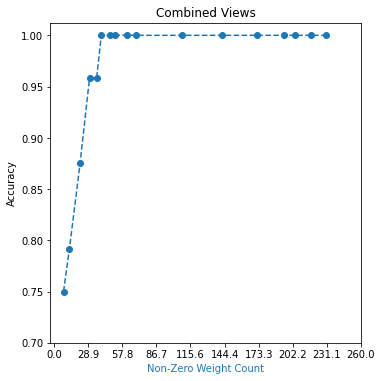

In [37]:
fig=plt.figure(figsize=(20, 10))

#Non-Zero Weight Count Plot
ax=fig.add_subplot(2, 4, j+1, label="1")

ax.plot(nonzero_weight_cnt, accuracy, marker='o', color="C0", linestyle='dashed')

ax.set_xlabel("Non-Zero Weight Count", color="C0")
ax.set_ylabel("Accuracy", color="Black")
ax.tick_params(axis='x', colors="Black")
ax.tick_params(axis='y', colors="Black")
ax.set_yticks([x * 0.05 for x in range(14, 21)])
# ax.set_yticks([x * 0.05 for x in range(4, 21)])
ax.set_xticks(np.linspace(0,260,10))

ax.set_title("Combined Views")

fig.tight_layout()

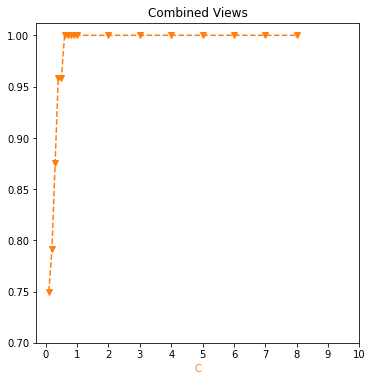

In [38]:
fig=plt.figure(figsize=(20, 10))

#C Value Line
ax2=fig.add_subplot(2, 4, j+1, label="2")

ax2.plot(regularizers, accuracy, marker='v', color="C1", linestyle='dashed')

ax2.set_xlabel('C', color="C1") 
ax2.set_ylabel('')
ax2.tick_params(axis='x', colors="Black")
ax2.set_yticks([x * 0.05 for x in range(14, 21)])
# ax2.set_yticks([x * 0.05 for x in range(4, 21)])
ax2.set_xticks(np.linspace(0,10,11))

ax2.set_title("Combined Views")

fig.tight_layout()

### Train Model WITH SMALLER REGULARIZERS, Get Accuracies, Get # of Non-Zero Weights

In [40]:
accuracy = []
nonzero_weight_cnt = []
regularizers = np.linspace(.05,1,20)

#Convert to Dataframe
strip_row_avg = pd.DataFrame(joined_multiview_strip_row_avg_list)

#Get Features
df_feat = strip_row_avg.iloc[:,:-2]

#Get Targets & Format to 1D vector
df_target = strip_row_avg.iloc[:,-1:]
df_target = df_target.values.ravel()

# print(np.shape(df_feat))
# print(np.shape(df_target))

#Create Model
model = LinearSVC()

#Set Model Parameters
for r_c in regularizers:

    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False,
                    tol=2e-3,
                    C=r_c)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Append Count of Number of Non-Zero Weights
    nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))

    # print("N_Features_In w/ C = "+str(r_c)+' '+str(model.n_features_in_))

# print('Accuracy: '+str(accuracy))
# print('Regularizers: '+str(regularizers))
# print('Nonzero_Weight_Cnt: '+str(nonzero_weight_cnt))

results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
display(results)

,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,0.667,0.05,3
1,0.750,0.10,8
2,0.792,0.15,11
3,0.792,0.20,13
4,0.875,0.25,15
5,0.875,0.30,22
6,0.917,0.35,26
7,0.958,0.40,30
8,0.958,0.45,36
9,0.958,0.50,36


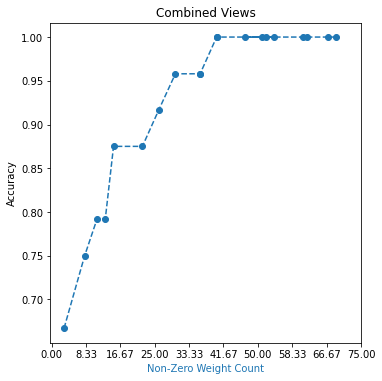

In [41]:
fig=plt.figure(figsize=(20, 10))

#Non-Zero Weight Count Plot
ax=fig.add_subplot(2, 4, j+1, label="1")

ax.plot(nonzero_weight_cnt, accuracy, marker='o', color="C0", linestyle='dashed')

ax.set_xlabel("Non-Zero Weight Count", color="C0")
ax.set_ylabel("Accuracy", color="Black")
ax.tick_params(axis='x', colors="Black")
ax.tick_params(axis='y', colors="Black")
ax.set_yticks([x * 0.05 for x in range(14, 21)])
# ax.set_yticks([x * 0.05 for x in range(4, 21)])
ax.set_xticks(np.linspace(0,75,10))

ax.set_title("Combined Views")

fig.tight_layout()

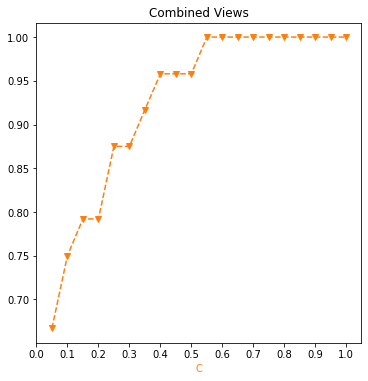

In [42]:
fig=plt.figure(figsize=(20, 10))

#C Value Line
ax2=fig.add_subplot(2, 4, j+1, label="2")

ax2.plot(regularizers, accuracy, marker='v', color="C1", linestyle='dashed')

ax2.set_xlabel('C', color="C1") 
ax2.set_ylabel('')
ax2.tick_params(axis='x', colors="Black")
ax2.set_yticks([x * 0.05 for x in range(14, 21)])
# ax2.set_yticks([x * 0.05 for x in range(4, 21)])
ax2.set_xticks(np.linspace(0,1,11))

ax2.set_title("Combined Views")

fig.tight_layout()